# Fast Laplace Transform
## Yen Lee Loh, 2022-8-7

This repository provides a Python implementation of Fast Laplace transform (FLT) algorithm by Yen Lee Loh.
The discrete Laplace transform (DLT) in statistical mechanical terminology is
    $$ Z_m = \sum_n e^{-\beta_m U_n} W_n \quad(m=1,\dots,N;n=1,\dots,N) $$
where 
$U_n$ are input abscissae (energy levels),
$W_n$ are input ordinates (multiplicities or degeneracies),
$\beta_m$ are output abscissae (inverse temperatures),
and $Z_m$ are output ordinates (values of the partition function).
Brute-force evaluation of the DLT takes $O(MN)$ effort.
The FLT algorithm usually takes between $O(M+N)$ and $O( (M+N)^{1.5} )$ effort.
It computes the DLT to a given fractional error even when the inputs vary over very large ranges.
`flt.ipynb` is a JupyterLab notebook (tested on conda 4.12.0 on Ubuntu 20.04 with JupyterLab 3.3.2).


## 1. Code

In [46]:
#========================================
# RUN THIS CELL!
#========================================

#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom,loggamma,betaln,factorial
from numpy import floor,ceil,sqrt,exp,log,arange,linspace
from matplotlib.patches import Rectangle
import time
np.set_printoptions(linewidth=200,precision=2,threshold=45,floatmode='maxprec',suppress=True)
plt.rcParams['font.size'] = 14

import pandas
pandas.set_option('display.width', 200)
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_colwidth', None)
pandas.set_option("display.precision", 2)
#pandas.reset_option("display.float_format")
pandas.set_option("display.float_format", "{:0.4g}".format)

#========================================
# MATH UTIITIES
#========================================
import functools
def factors(n):    
  """Return a list of factors of the integer n"""
  return functools.reduce(list.__add__, 
    ([i, n//i] for i in range(1, int(n**0.5) + 1) if n%i==0))
def smallFactors(n):
  """Return a list of factors of the integer n that are not larger than sqrt(n)"""
  return functools.reduce(list.__add__, 
    ([i] for i in range(1, int(n**0.5) + 1) if n%i==0))
def twoFactors(n):
  """Return a factorization n=p*q such that p and q are as similar as possible"""
  i = max (smallFactors(n))
  return [i, n//i]
def logLogistic(x):
  """Returns log(1+exp(-x)), avoiding overflow"""
  if (x>0):
    return np.log (1 + np.exp(-x))
  return -x + np.log (1 + np.exp(x))
logLogistic = np.frompyfunc(logLogistic, 1, 1)  # make this a ufunc (universal function)

def logBinomial (n,r):
  """Returns the log of the binomial coefficient Binomial(n,r), avoiding overflow"""
  return -betaln(1+r,1+n-r) - log(1+n) # loggamma(n)-loggamma(k)-loggamma(n-k) doesn't work


#========================================
# CONSTRUCTING TEST DATASETS
#========================================
def UnSnBinomial (nSpins, xi=1):
  """Returns energies and multiplicities [Un,Sn] for the 'binomial' model with nSpins spins"""
  nn = np.arange(nSpins+1)
  Un = nn*xi
  Sn = logBinomial(nSpins,nn) #np.log (binom(nSpins,nn))
  return [Un,Sn]
def toydataBinomial (nmax, mmax, Ur, Br):
  """
  Constructs a testing data set for the discrete Laplace transform.
  
    Arguments:
      nmax    number of energies
      mmax    number of inverse temperatures
      Ur      size of energy range
      Br      size of inverse temperature range
      
    Returns:
      Un[0:nmax]      energies (numpy array)
      Sn[0:nmax]      log multiplicities for a suitable 'binomial' model
      Bm[0:mmax]      inverse temperatures
      Fm[0:mmax]      log partition function computed analytically
  """
  nSpins = nmax-1
  xi = Ur/nSpins
  [Un,Sn] = UnSnBinomial (nSpins, xi)
  Bm = np.linspace (-Br/2, Br/2, mmax)
  Fm = nSpins * logLogistic (Bm*xi)     # nSpins*log (1 + exp(-Bm*xi))
  return [Un,Sn,Bm,Fm]

def UnSnDoubleBinomial (nSpinsA, nSpinsB, xiA=1.0, xiB=np.sqrt(2)):
  """
  Returns energies and multiplicities [Un,Sn] for the 'double binomial' model
  consisting of nSpinsA two-level systems of energy xiA
  and nSpinsB two-level systems of energy xiB
  """
  
  [UnA,SnA] = UnSnBinomial (nSpinsA, xiA)
  [UnB,SnB] = UnSnBinomial (nSpinsB, xiB)
  Un = np.add.outer(UnA, UnB).flatten()
  Sn = np.add.outer(SnA, SnB).flatten()
  indices = np.argsort (Un)
  Un = Un[indices]
  Sn = Sn[indices]
  return [Un,Sn]
def toydataDoubleBinomial (nmax, mmax, Ur, Br, Umin=0, xiRatio=np.sqrt(2)):
  """
  Constructs a testing data set for the discrete Laplace transform.
  
    Arguments:
      nmax    number of energies
      mmax    number of inverse temperatures
      Ur      size of energy range
      Br      size of inverse temperature range
      Umin    lowest end of energy range
      xiRatio ratio of energies of sets of two-level systems (should be irrational)
      
    Returns:
      Un[0:nmax]      energies (numpy array)
      Sn[0:nmax]      log multiplicities for a suitable 'binomial' model
      Bm[0:mmax]      inverse temperatures
      Fm[0:mmax]      log partition function computed analytically
  """
  [lA,lB] = twoFactors (nmax)
  [nSpinsA,nSpinsB] = [lA-1,lB-1]
  xiA = Ur / (nSpinsA * 1.0 + nSpinsB * xiRatio)
  xiB = xiA * xiRatio
  [Un,Sn] = UnSnDoubleBinomial (nSpinsA, nSpinsB, xiA, xiB)
  Un += Umin
  Bm = np.linspace (-Br/2, Br/2, mmax)
  Fm = nSpinsA*logLogistic(Bm*xiA) + nSpinsB*logLogistic(Bm*xiB) - Bm*Umin
  return [Un,Sn,Bm,Fm]


#==================================================
# HELPER FUNCTIONS
#==================================================
#======== findHullFilled (xn, yn)
def findHullFilled (xn, yn):
  """
  Finds the upper convex hull of a set of points.
  
    Arguments:
      xn   list or array of floats (assumed to be in non-decreasing order)
      yn   list or array of floats
      
    Returns:
      ynHull    list or array of floats defining the upper convex hull
  """
  #======== Apply Andrew's monotone chain convex hull algorithm
  nmax = len(xn)
  assert len(yn) == nmax
  nn = []
  for n in range(nmax):
    while len(nn) >= 2 and \
      (yn[n]-yn[nn[-1]]) / (xn[n]-xn[nn[-1]]) > (yn[nn[-1]]-yn[nn[-2]]) / (xn[nn[-1]]-xn[nn[-2]]):
      nn.pop()
    nn.append (n)
  #======== Fill in the hull
  # For example, if nn=[0,4,6,9],
  # we need to set ynHull[j] for j=1,2,3,5,7,8 by linear interpolation.
  ynHull = yn.copy()
  for i in range(len(nn)-1):
    n1 = nn[i]
    n2 = nn[i+1]
    for n in range(n1+1,n2+1):
      ynHull[n] = yn[n1] + (xn[n]-xn[n1])*(yn[n2]-yn[n1])/(xn[n2]-xn[n1])
  return ynHull


#======== findCellMappings (Un, Uj)
def findCellMappings (Un, Uj):
  """
    Arguments:
      Un[0:nmax]        list of energies
      Uj[0:jmax+1]      list of delimiting energies (interval specs)
    Returns:
      nj[0:jmax+1]      array of indices for first energy in each interval
      jn[0:nmax]        array of indices showing which interval each energy lies in
  """
  nmax = len(Un)
  jmax = len(Uj) - 1
  assert Uj[0]<=Un[0] and Uj[-1]>=Un[-1], "ERROR: Cell spec does not bracket data!"
  nj = np.zeros (jmax+1,dtype='int')
  jn = np.zeros (nmax,dtype='int')
  j = 0
  for n in range(nmax+1):
    while j<=jmax and (n>=nmax or Uj[j]<=Un[n]):
      nj[j] = n
      j += 1
    if n<nmax:
      jn[n] = min(j-1,jmax-1)  # hacky
    nj[jmax] = nmax
  return [nj,jn]

#======== logSumExp
def logSumExp (F1, F2):
  """
  Calculates log(exp(F1) + exp(F2)), avoiding overflow.
  
    Arguments:
      F1,F2     floats (or arrays of floats)
  """
  F0 = np.amax([F1, F2], axis=0) # compare elements pair by pair
  return F0 + log(exp(F1-F0) + exp(F2-F0))

#==================================================
# DISCRETE LAPLACE TRANSFORM ALGORITHMS
#==================================================
def DLTDirect_unsafe (Un, Sn, Bm):
  """This simple implementation is vulnerable to overflow."""
  nmax = len(Un)
  mmax = len(Bm)
  Zm = np.zeros (mmax)
  for m in range(mmax):
    for n in range(nmax):
      Zm[m] += exp (Sn[n] - Bm[m]*Un[n])
  Fm = log(Zm)
  return Fm

def DLTDirect (Un, Sn, Bm):
  """
  Calculates the discrete Laplace transform Z[m] = sum_n exp(-B[m] U[n]) W[n],
  avoiding overflow.
  
    Arguments:
      Un           array of input abscissae (sources; energies)
      Sn = ln Wn   array of input values (entropies)
      Bm           array of output abscissae (targets; inverse temperatures)
    Returns:
      Fn = ln Zn   array of output values (log partition function)
  """
  #nmax = len(Un)
  mmax = len(Bm)
  Fm = np.zeros (mmax)
  for m in range(mmax):
    Yn = Sn - Bm[m] * Un   # array of exponents
    Y0 = max(Yn)
    Fm[m] = Y0 + log (np.sum (exp (Yn - Y0)))
  return Fm

def DLTTaylor_unsafe (Un, Sn, Bm, kmax):
  """This simple implementation is vulnerable to overflow."""
  nmax = len(Un)
  mmax = len(Bm)
  Mk = np.zeros (kmax)
  for k in range(kmax):
    for n in range(nmax):
      Mk[k] += Un[n]**k * exp (Sn[n]) / factorial(k)   
  Zm = np.zeros (mmax)
  for m in range(mmax):
    for k in range(kmax):
      Zm[m] += (-Bm[m])**k * Mk[k]
  return log(Zm)

def DLTTaylor (Un, Sn, Bm, kmax):
  """
  Calculates the discrete Laplace transform using the Taylor strategy.
  Given the inputs Wn, we compute the moments Mk, 
  and then use these as Taylor coefficients to construct Zm:
  
  Mk[k] = 1/k! * sum_{n}     Un[n]**k * Wn[n]
  Zm[m] =        sum_{k}  (-Bm[m])**k * Mk[k]
  
    Arguments:
      Un           input abscissae (must be zero or positive)
      Sn = ln Wn   input values
      Bm           output abscissae (must be zero or negative)
      kmax         nu
    Returns:
      Fn = ln Zn   output values
  """  
  nmax = len(Un)
  mmax = len(Bm)
  
  Sshf = max(Sn)
  Uscal = max(Un)           # internal rescaling factor
 
  Mk = np.zeros (kmax)
  for n in range(nmax):
    U = Un[n] / Uscal       # rescale to avoid overflow
    T = U**0 * exp(Sn[n] - Sshf)   # T = U_n^0 W_k
    Mk[0] += T              # usually U_n^0==0 but not always!
    for k in range(1,kmax):
      T *= U                # now T = U_n^k W_k
      Mk[k] += T
  
  fac = 1.0
  for k in range(2,kmax):   # can start doing this from k=2 onwards
    fac *= k                # now fac = k!
    Mk[k] /= fac
  
  Zm = np.zeros (mmax)
  for m in range(mmax):
    minusB = -Bm[m] * Uscal # restore the rescaling factor
    T = minusB**0           # here T = 1
    Zm[m] += Mk[0] * T      # Z_m += (-B_m)^0 M_k
    for k in range(1,kmax):
      T *= minusB           # now T = (-B_m)^k
      Zm[m] += T * Mk[k]    # Z_m += (-B_m)^k M_k
  return log(Zm) + Sshf


#==================================================
# FAST LAPLACE TRANSFORM MAIN ROUTINE
#==================================================
def DLTFast (Un, Sn, Bm, xc=9.2, kmax=44, eta=2.0**-53):
  """
  Implements the fast discrete Laplace transform (Yen Lee Loh, 2022-8-1).
  
    Arguments:
      Un           input abscissae (must be zero or positive)
      Sn = ln Wn   input values
      Bm           output abscissae (must be zero or negative)
      xc           maximum area of cell in (U,S) space
                   (i.e., maximum exponent of DLT kernel for
                   the purposes of Taylor expansion)
      kmax         order of Taylor expansion (number of moments computed)
      eta          target fractional accuracy (for top-down strategy)
      
    Returns:
      Fn = ln Zn   output values
      
    Returned diagnostics:
      Fm           output values
      SnHull       convex hull of data
      nmL,nmA,nmR  indices of dominant energy and windows of significance 
      Uj,Bi        interval specifications
      nj,jn,mi,im  indices of mappings between intervals and points
      cellsTotal   total number of cells in partitioning scheme (inc. empty)
      cellsDirect  number of cells evaluated using direct DLT
      cellsTaylor  number of cells evaluated using Taylor method
  """  
  logooeta = log(1/eta)

  nmax = len(Un)
  Umin = min(Un)
  Umax = max(Un)
  Ur = Umax - Umin
  mmax = len(Bm)
  Bmin = min(Bm)
  Bmax = max(Bm)
  Br = Bmax - Bmin
  #-------- DEFINE CELL GRID
  jmax = ceil (sqrt(Br*Ur/xc*nmax/mmax)) . astype(int)
  imax = ceil (sqrt(Br*Ur/xc*mmax/nmax)) . astype(int)
  Uj = linspace (Umin, Umax, jmax+1)
  Bi = linspace (Bmin, Bmax, imax+1)
  #-------- FIND HULL AND WINDOWS
  SnHull = findHullFilled (Un, Sn)
  nL = nA = nR = 0
  nmL = np.zeros (mmax,dtype='int')
  nmA = np.zeros (mmax,dtype='int')
  nmR = np.zeros (mmax,dtype='int')
  for m in reversed(range(mmax)):
    while nA<nmax-1 and (SnHull[nA+1]-SnHull[nA])/(Un[nA+1]-Un[nA]) > Bm[m]:
      nA += 1
    while nL<nA and SnHull[nL] < SnHull[nA] - logooeta + (Un[nL]-Un[nA])*Bm[m]:
      nL += 1
    if nR < nA:
      nR = nA
    while nR<nmax-1 and SnHull[nR] > SnHull[nA] - logooeta + (Un[nR]-Un[nA])*Bm[m]:
      nR += 1
    nmL[m] = nL
    nmA[m] = nA
    nmR[m] = nR
  #-------- ESTABLISH CELL-TO-POINT INDEXING
  [nj,jn] = findCellMappings (Un,Uj)
  [mi,im] = findCellMappings (Bm,Bi)
  #-------- IDENTIFY CELLS OF IMPORTANCE
  jiL = jn[nmL[mi[arange(imax)+1]-1]]
  jiR = jn[nmR[mi[arange(imax)]]]
  #-------- INITIALIZE ACCUMULATAORS (COMBINED STRATEGY)
  cellsTotal = imax*jmax
  ops = cellsTaylor = cellsDirect = 0
  #Fm = np.full (mmax, -np.inf, dtype=np.float64) 
  Fm = np.full (mmax, -1e300, dtype=np.float64) 
  #-------- LOOP OVER TEMPERATURE INTERVALS
  for i in range(imax):
    B0 = Bi[i+1]
    mSel = range (mi[i],mi[i+1])
    Mc = len(mSel)
    BmSel = Bm[mSel]
    #-------- LOOP OVER ENERGY INTERVALS
    #for j in range(jmax):
    for j in range(jiL[i],jiR[i]+1):
      U0 = Uj[j]
      nSel = range (nj[j],nj[j+1])
      Nc = len(nSel)
      if Nc*Mc==0:
        continue # empty cell
      
      UnSel = Un[nSel]
      SnSel = Sn[nSel]
      S0 = SnSel[0]  # use this as a shift
      #-------- COMPUTE SHIFTED ENERGIES AND TEMPERATURES
      UnTil = UnSel - U0    # Variables with tildes are shifted
      BmTil = BmSel - B0
      SnTil = SnSel - B0 * UnTil - S0  # Careful with this one  
      if Nc*Mc < kmax*(Nc+Mc):
        #-------- EXECUTE CELL USING DIRECT METHOD
        FmTil = S0 - BmSel*U0 + DLTDirect(UnTil,SnTil,BmTil)
        Fm[mSel] = logSumExp (Fm[mSel], FmTil)
        cellsDirect += 1
        ops += Nc*Mc
      else:
        #-------- EXECUTE CELL USING TAYLOR METHOD.........
        FmTil = S0 - BmSel*U0 + DLTTaylor(UnTil,SnTil,BmTil,kmax)
        Fm[mSel] = logSumExp (Fm[mSel], FmTil)
        cellsTaylor += 1
        ops += kmax*(Nc+Mc)

  # Note that nmL,nmA,nmR pertain to top-down strategy
  # and Uj,nj,jn,...,jiL pertain to bottom-up strategy
  return [Fm,SnHull,nmL,nmA,nmR, Uj,nj,jn,Bi,mi,im,jiL,jiR, cellsTotal,cellsDirect,cellsTaylor,ops]    

#==================================================
# VISUALIZATION CODE
#==================================================

#======== PLOT SIGNIFICANCE WINDOWS
def plotWindows (Un, Bm, nmL, nmA, nmR):
  plt.plot (Un[nmL], Bm, "brown")
  plt.plot (Un[nmA], Bm, "brown")
  plt.plot (Un[nmR], Bm, "brown")
#======== PLOT CELL PARTITIONING SCHEME
def plotCells (Uj, Bi, jiL, jiR):
  for i in range(len(Bi)-1):
    for j in range(jiL[i],jiR[i]+1): #range(len(Uj)-1):
      plt.gca().add_patch(Rectangle(
        (Uj[j],Bi[i]), Uj[j+1] - Uj[j], Bi[i+1]-Bi[i],
        linewidth=1,edgecolor="000",facecolor="#fed"))
  plt.xlabel (r"$U$")
  plt.ylabel (r"$\beta$", rotation=0);  


#==================================================
# FULL DEMONSTRATION CODE
#==================================================
def demo (Un,Sn,Bm,FmExact):  
  """
  Demonstrate the fast Laplace transform algorithm 
  compared to the brute-force discrete Laplace transform.  
  Visualize inputs, operations, outputs, and errors.
  
    Arguments:
      Un[0:nmax]     numpy.array   input abscissae (energies)
      Sn[0:nmax]     numpy.array   input ordinates (multiplicities)
      Bm[0:mmax]     numpy.array   output abscissae (inverse temperatures)
      Fm[0:mmax]     numpy.array   output ordinates (log partition function) 
                                   computed analytically for comparison
  """
  #======== Do brute-force discrete Laplace transform
  FmBrute = DLTDirect (Un, Sn, Bm)

  #======== Do fast Laplace transform
  [FmFast,SnHull,nmL,nmA,nmR, Uj,nj,jn,Bi,mi,im,jiL,jiR, cellsTotal,cellsDirect,cellsTaylor,ops] \
  = DLTFast (Un, Sn, Bm)

  #======== Plot
  fig,axs = plt.subplots(1,4,figsize=(16,4))
  plt.tight_layout (w_pad=2)

  plt.subplot (1,4,1)
  plt.title ("Input $S(U)$")
  plt.plot (Un, Sn, 'b.', markersize=2, label="$\{U_n,S_n\}$")
  plt.plot (Un, SnHull, '-', color='purple', label='hull')
  plt.xlabel (r'$U$')
  plt.ylabel (r'$S$', rotation=0)
  plt.legend ()

  plt.subplot (1,4,2)
  plt.title ("Cells and windows")
  plotWindows (Un, Bm, nmL, nmA, nmR)
  plotCells (Uj, Bi, jiL, jiR)

  plt.subplot (1,4,3)
  plt.title (r"Output $\mathcal{F}(\beta)$")
  plt.plot (Bm, FmFast, "o-", color='red', markersize=6, label="FLT")
  plt.plot (Bm, FmBrute, "x", color='#C90', markersize=4, label="Brute")
  plt.plot (Bm, FmExact, "--", label="Exact")
  plt.xlabel (r'$\beta$')
  plt.ylabel (r'$\mathcal{F}$', rotation=0)
  plt.legend ()

  plt.subplot (1,4,4)
  plt.title (r"Error $\mathcal{F}_{\mathrm{err}}$")
  plt.plot (Bm, abs(FmFast-FmExact), "o", color='red', markersize=6, label="FLT")
  plt.plot (Bm, abs(FmBrute-FmExact), "x", color='#C90', markersize=4, label="Brute")
  plt.yscale ("log")
  plt.ylim ([1e-16,1e-10])
  plt.xlabel (r'$\beta$')
  plt.ylabel (r'$\mathcal{F}_{\mathrm{err}}$', rotation=0)
  plt.legend ()
  
  #print ("Maximum error: {:.3g} ".format( max(abs(FmFast-FmExact)) ))
  #print ("Total, direct, Taylor cells: ", [cellsTotal, cellsDirect, cellsTaylor])
  
#==================================================
# BENCHMARKING CODE
#==================================================
def benchmark (nmax, mmax, Ur, Br):
  """
  Compare the fast discrete Laplace transform algorithm with brute-force evaluation
  with regard to operation count, CPU time, and accuracy.
  
    Arguments:
      nmax      number of energies
      mmax      number of temperatures
      Ur        energy range
      Br        temperature range
  """
  
  # Change to toydataDoubleBinomial(...) if desired
  [Un,Sn,Bm,FmExact] = toydataBinomial (nmax, mmax, Ur, Br)
  
  timeStart = time.perf_counter()
  FmBrute = DLTDirect (Un,Sn,Bm)
  timeBrute = time.perf_counter() - timeStart
  opsBrute = nmax * mmax
  errBrute = max(abs(FmBrute - FmExact))
  
  timeStart = time.perf_counter()
  [FmFast,SnHull,nmL,nmA,nmR, Uj,nj,jn,Bi,mi,im,jiL,jiR, cellsTotal,cellsDirect,cellsTaylor,ops] \
  = DLTFast (Un, Sn, Bm)
  timeFast = time.perf_counter() - timeStart
  opsFast = ops
  errFast = max(abs(FmFast - FmExact))
  
  return [nmax, mmax, Ur, Br, opsBrute, opsFast, cellsTotal, cellsDirect, cellsTaylor,
            timeBrute, timeFast, errBrute, errFast]

---
## 2. Demos (Fast DLT vs brute-force DLT)

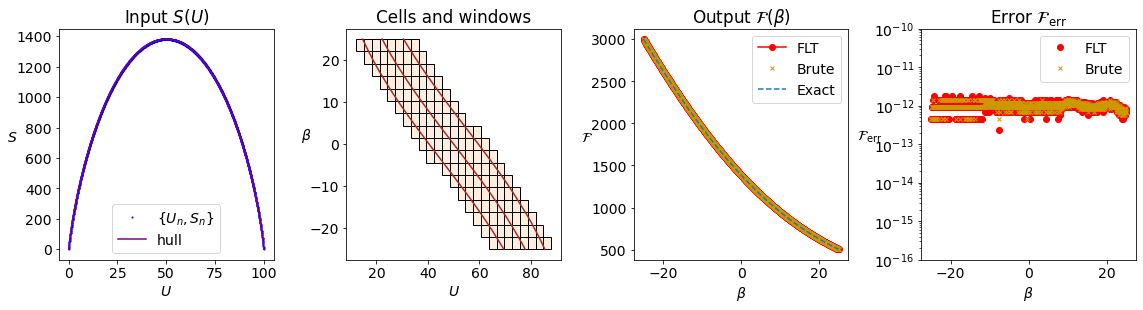

In [47]:
[Un,Sn,Bm,FmExact] = toydataBinomial (nmax=2000, mmax=1000, Ur=100.0, Br=50.0)
demo (Un,Sn,Bm,FmExact)

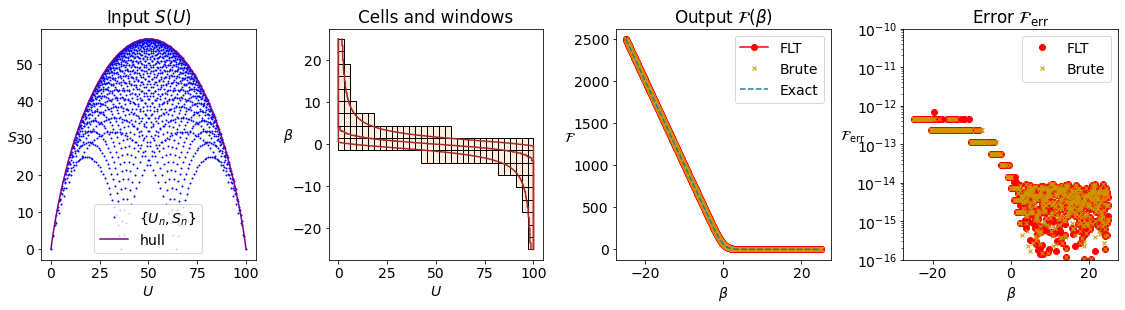

In [48]:
[Un,Sn,Bm,FmExact] = toydataDoubleBinomial (nmax=2000, mmax=1000, Ur=100.0, Br=50.0)
demo (Un,Sn,Bm,FmExact)

---
## 3. Benchmarks (Fast DLT vs brute-force DLT)

In [75]:
#==============================
# Fixed Ur=Br=1000, varying N=M
#==============================
data = []
Ur = 1000.
Br = 1000.
data.append (benchmark (10,10, Ur,Br))
data.append (benchmark (100,100, Ur,Br))
data.append (benchmark (1000,1000, Ur,Br))
data.append (benchmark (10000,10000, Ur,Br))
df = pandas.DataFrame(data)
df.round ({'Ur': 0, 'Br': 0, 'timeBrute': 1})
df.columns = ["nmax", "mmax", "Ur", "Br", "opsBrute", "opsFast", "cellsTotal", "cellsDirect", "cellsTaylor",
            "timeBrute", "timeFast", "errBrute", "errFast"]
print (df)

    nmax   mmax   Ur   Br   opsBrute  opsFast  cellsTotal  cellsDirect  cellsTaylor  timeBrute  timeFast  errBrute   errFast
0     10     10 1000 1000        100       15      108900           15            0  0.0002559  0.007832 5.821e-11 5.821e-11
1    100    100 1000 1000      10000      150      108900          150            0   0.002156   0.01423 5.821e-11 5.821e-11
2   1000   1000 1000 1000    1000000     7645      108900          733            0    0.07241   0.05379 5.821e-11 1.164e-10
3  10000  10000 1000 1000  100000000  1116203      108900         1209            0       5.89    0.5193 1.164e-10 1.164e-10


In [76]:
#==============================
# Fixed N=M=10000, varying Ur=Br
#==============================
data = []
mmax = nmax = 10000
data.append (benchmark (mmax,nmax, 1., 1.))
data.append (benchmark (mmax,nmax, 10., 10.))
data.append (benchmark (mmax,nmax, 100., 100.))
data.append (benchmark (mmax,nmax, 1000., 1000.))
data.append (benchmark (mmax,nmax, 10000., 10000.))
df = pandas.DataFrame(data)
df.round ({'Ur': 0, 'Br': 0, 'timeBrute': 1})
df.columns = ["nmax", "mmax", "Ur", "Br", "opsBrute", "opsFast", "cellsTotal", "cellsDirect", "cellsTaylor",
            "timeBrute", "timeFast", "errBrute", "errFast"]
print (df)

    nmax   mmax    Ur    Br   opsBrute  opsFast  cellsTotal  cellsDirect  cellsTaylor  timeBrute  timeFast  errBrute   errFast
0  10000  10000     1     1  100000000   880000           1            0            1      5.649    0.2826 2.728e-12 2.728e-12
1  10000  10000    10    10  100000000  1760000          16            0            8      5.536    0.5155 2.728e-12 3.638e-12
2  10000  10000   100   100  100000000  3653144        1089            0          137      5.675      1.02 5.457e-12 7.276e-12
3  10000  10000  1000  1000  100000000  1116203      108900         1209            0      5.618    0.5013 1.164e-10 1.164e-10
4  10000  10000 1e+04 1e+04  100000000    74586    10870209         6331            0      5.697     0.471  1.49e-08  1.49e-08
